# CapStone Project - The Battle of the Neighborhoods(Week 2)

## Applied Data Science Project - Vcare & Uplay

## Table of Contents
 - [Introduction - Business Problem](#introduction)
 - [Data](#data)
 - [Methodology](#methodology)
 - [Analysis](#analysis)
 - [Results & Discussion](#results)
 - [Conclusion](#conclusion)

## Introduction - Business Problem <a id ='introduction'></a>

The client is interested in opening a modern daycare unlike the conventional daycare which accepts fullday or halfday schedule
for kids. This modern daycare will be used to support kids 0-4 years on a short term basis when the parents/mothers can engage
in fitness/social activities. This approach can attract more customers as lot of parents are interested in taking a break from 
small children but they are not provided safe and secure options. __The targeted neighborhoods for this business will be the Toronto/Ottawa Neighborhood__. As there are other governement regulations that can affect the business initiation, __the client requires more than one choice to be suggested__.

__The neighborhood should have sufficient amount of small kids and families with relatively continuous income. The daycare should  have the flexibility to have tieups with fitness centers or clubs in the neighborhood to gain more attraction.__

Data analysis methods will be used to study the daya and identify the choice of neighborhoods for the client.

## Data <a id='data'></a>

The business requirement requires us to study the below parameters:
 
 - Since we need to study all the neighborhoods to clearly understand the family background with the financial capability.
 - We will need geographical coordinates for Ottawa and Toronto neighborhoods td understand proximity.
 - Supportive business operations in the vicinity.
 
 We will use the postal codes to gather the Toronto & Ottawa Neighborhoods.
 Using the postal codes, the census data can be extracted from the Canadian government website to study the population statistics.
 The census data requires major data cleaning and screening to understand the impact of the variables. 
 The venues that can help with tie-up strategies are identified using the Foursquare API with the Neighborhood, latitude and longitude details

In [1]:
#!pip install geopy
#!pip install folium

### The webpage with the postal codes of Ottawa and Toronto will be scrapped to extract the details in a Dataframe using beautiful soup with algorithm 'lxml'. Relatively most efficient to extract by navigating the tree

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

from collections import Counter
import json
from sklearn.cluster import KMeans
from pandas import json_normalize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from geopy.geocoders import Nominatim 
import folium

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_K"

### The function below uses the input URL and extracts the Postalcode, Borough and Neighborhood information to a Dataframe.The data with the Neighborhood as 'Not Assigned' on the webpage. 

In [3]:
def webscrap_postal(url):

    column_names = ['PostalCode', 'Borough', 'Neighborhood']
    t_rows = 0
    t_cols = 0
    area = []
    borough=[]
    neighborhood=[]
    postalcode = []

    source = requests.get(url).text
    soup = BeautifulSoup(source, 'lxml')
    cols = soup.find('td')
    postalcode = cols.b.text
    span = cols.span.text

    postalcode=[]
    areadetails=[]

    for cols in soup.find_all('td'):
        if cols.b != None:
            postalcode.append(cols.b.text)
        if cols.span != None:
            areadetails.append(cols.span.text)

    for x in areadetails:
        boroname = ""
        neighdetails = ""
        if (x.find("(") != -1):
            boroname = x[:x.find("(")]
            neighdetails = x[x.find("("):]
            neighdetails = neighdetails.replace("(","")
            neighdetails = neighdetails.replace(")","")
            neighdetails = neighdetails.replace(" / ", ", ")
            borough.append(boroname)
            neighborhood.append(neighdetails)
        else:
            borough.append('Not assigned')
            neighborhood.append('Not assigned')

    df = pd.DataFrame([postalcode, borough, neighborhood])
    df_Trans = df.T
    df_Trans.head(5)
    df_Trans.columns = ['Postalcode', 'Borough', 'Neighborhood']
    
    df_Trans.head(5)
    df_Trans.drop(df_Trans[df_Trans['Borough']=='Not assigned'].index, inplace=True)
    df_Trans.drop(df_Trans[df_Trans['Postalcode']=='K1A'].index, inplace=True)

    return df_Trans

In [4]:
ottawa_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_K"
ottawa_complete_df = webscrap_postal(ottawa_url)

In [5]:
toronto_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
toronto_complete_df = webscrap_postal(toronto_url)

### The dataframe is created with 3 columns, Postalcode, Borough & Neighborhood containing only Ottawa and Toronto

#### Extract the postal codes to refelect the Ottawa Borough only to study the businesses in Ottawa

In [6]:
ottawa_df = ottawa_complete_df[ottawa_complete_df['Borough']=='Ottawa'].reset_index(drop=True)
ottawa_df.head()

,Postalcode,Borough,Neighborhood
0,K2A,Ottawa,"Highland Park, McKellar Park /Westboro /Glabar..."
1,K4A,Ottawa,Fallingbrook
2,K1B,Ottawa,"Blackburn Hamlet, Pine View, Sheffield Glen"
3,K2B,Ottawa,"Britannia /Whitehaven, Bayshore, Pinecrest"
4,K4B,Ottawa,Navan


In [7]:
ottawa_df.shape

(40, 3)

#### Extract the postal codes to refelect the Borough containing Toronto only to study the businesses in Toronto

In [8]:
toronto_df = toronto_complete_df[toronto_complete_df['Borough'].str.contains('Toronto')]

In [9]:
toronto_df.head(5)

,Postalcode,Borough,Neighborhood
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
13,M5B,Downtown Toronto,"Garden District, Ryerson"
22,M5C,Downtown Toronto,St. James Town
30,M4E,East Toronto,The Beaches
31,M5E,Downtown Toronto,Berczy Park


### Using the geospatial dataset, the latitude and longitude coordinates has been extracted from the file for the postal codes 

In [10]:
geo_coordinate_otw_df = pd.read_csv('GeospatialCoordinates_Ottawa.csv')
geo_coordinate_tor_df = pd.read_csv('Geospatial_Coordinates.csv')
geo_coordinate_otw_df.head(5)
geo_coordinate_tor_df.head(5)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
ottawa_df = ottawa_df.join(geo_coordinate_otw_df.set_index('Postalcode'), on='Postalcode')

In [12]:
toronto_df = toronto_df.join(geo_coordinate_tor_df.set_index('Postal Code'), on='Postalcode')

In [13]:
ottawa_df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,K2A,Ottawa,"Highland Park, McKellar Park /Westboro /Glabar...",45.3884,-75.7456
1,K4A,Ottawa,Fallingbrook,45.4738,-75.4780
2,K1B,Ottawa,"Blackburn Hamlet, Pine View, Sheffield Glen",45.4317,-75.5645
3,K2B,Ottawa,"Britannia /Whitehaven, Bayshore, Pinecrest",45.3483,-75.8078
4,K4B,Ottawa,Navan,45.4210,-75.4267


In [14]:
toronto_df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
13,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
22,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
30,M4E,East Toronto,The Beaches,43.676357,-79.293031
31,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


### Using FourSquare API, lets us identify the neighborhoods with the most venues for categories like Playground, sports club, spa and more.

In [15]:
# @hidden_cell
CLIENT_ID = 'XVGF5FBRGJZJULLJEH45AC4H4QHSKFIDFNW4M0U1DFBM55QF' # your Foursquare ID
CLIENT_SECRET = '31MC3RPEJKUKGXTSMZILY140041DAKFMJXFM2O54T4N5T0MG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
       # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                 'Neighborhood Latitude', 
                 'Neighborhood Longitude', 
                  'Venue', 
                 'Venue Latitude', 
                 'Venue Longitude', 
                  'Venue Category']
    playground_only = nearby_venues[(nearby_venues['Venue Category'] == 'Playground') | 
                                    (nearby_venues['Venue Category'].str.contains('Child', na=False)) |
                                (nearby_venues['Venue Category'] == 'Yoga Studio') | 
                                    (nearby_venues['Venue Category'].str.contains('Gym', na=False)) |  
                                (nearby_venues['Venue Category'] == 'Sports Club') | 
                                    (nearby_venues['Venue Category'] == 'Spa') ]
    
    return(playground_only)

### Extracting Toronto Venues using the Latitude, Longitude & Neighborhood information.

In [18]:
LIMIT = 500 
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                 )
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
11,"Regent Park, Harbourfront",43.654260,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
41,"Regent Park, Harbourfront",43.654260,-79.360636,St Lawrence Community Centre Pool,43.649557,-79.365063,Gym Pool
75,"Regent Park, Harbourfront",43.654260,-79.360636,David Crombie Park,43.648575,-79.367766,Playground
123,"Garden District, Ryerson",43.657162,-79.378937,The Yoga Sanctuary,43.661499,-79.383636,Yoga Studio
146,"Garden District, Ryerson",43.657162,-79.378937,GoodLife Fitness Toronto 137 Yonge Street,43.651242,-79.378068,Gym


In [19]:
LIMIT = 500 
ottawa_venues = getNearbyVenues(names=ottawa_df['Neighborhood'],
                                   latitudes=ottawa_df['Latitude'],
                                   longitudes=ottawa_df['Longitude']
                                 )
ottawa_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
39,"Highland Park, McKellar Park /Westboro /Glabar...",45.3884,-75.7456,Pure Yoga,45.393364,-75.751636,Yoga Studio
50,"Highland Park, McKellar Park /Westboro /Glabar...",45.3884,-75.7456,Metta Massage & Yoga Clinic,45.390493,-75.757315,Yoga Studio
56,Fallingbrook,45.4738,-75.4780,Ezcape Spa,45.480171,-75.472941,Spa
107,"Britannia /Whitehaven, Bayshore, Pinecrest",45.3483,-75.8078,Starr Gymnastics,45.345047,-75.797859,Gym / Fitness Center
118,Orleans,45.4558,-75.5047,GoodLife Fitness,45.457172,-75.493859,Gym


### Census Data Cleaning

The targeted audience for the usecase are families with children 0-4 years. The families can be a couple household or a single
parent household. The census data has many number of rows indicating the household ownership information, family information, 
population by age, income by age, gross annual income, income percentage indicating government transfers. Government transfers 
means the support received by the family from the government.

We have extracted the files from the Canadian https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/index.cfm?Lang=E using the Postal codes from the webscrapped dataframes.

The information extracted are as below:
1. Count of children from 0-4 years
2. Family size run by couples
3. Family size run by single parents
4. Overall income percentage of the neighborhood through employment. The difference of this percentage shall indicate government support

In [29]:
def extract_census(df):
    pcode = df['Postalcode']
    lsize = []
    fsize = []
    cnt =[]   
    income = []
    childcount = []

    for i in pcode:
        filename = i+".csv"
        tempdf = pd.read_csv(filename, encoding="unicode_escape",  skipinitialspace = True)
        cnt_0to4 = tempdf[(tempdf['Topic'] == 'Age characteristics') & (tempdf['Characteristics'] == '0 to 4 years')]
        famsize = tempdf[tempdf['Characteristics'] == 'Average family size of couple economic families with children']
        lpsize = tempdf[tempdf['Characteristics'] == 'Average family size of lone-parent economic families' ]
        IncomeP = tempdf[tempdf['Characteristics'] == 'Employment income (%)' ]

        cnt.append(cnt_0to4.iloc[0]['Total'])
        fsize.append(famsize['Total'].values)
        lsize.append(lpsize['Total'].values)
        income.append(IncomeP['Total'].values)

    a1 = np.array(fsize)
    a2 = a1.flatten()
    a3 = np.array(lsize)
    a4 = a3.flatten()
    a5 = np.array(income)
    a6 = a5.flatten()
    list_of_tuples = list(zip(pcode, a6, cnt, a2, a4)) 
    census_data = pd.DataFrame(list_of_tuples, columns=['Postalcode', 'Income%','ChildCount','CFamilySize', 'LPFamilySize'])
    census_data.dropna(subset=['Income%','ChildCount','CFamilySize', 'LPFamilySize'],inplace=True)

    return census_data

In [30]:
otw_census = extract_census(ottawa_df)
print(otw_census.head())

  Postalcode  Income%  ChildCount  CFamilySize  LPFamilySize
0        K2A     65.1       710.0          3.9           2.5
1        K4A     80.2      3460.0          4.1           2.8
2        K1B     69.0       910.0          4.0           2.7
3        K2B     63.1      1695.0          4.1           2.8
4        K4B     71.6       175.0          3.9           2.7


In [31]:
tor_census = extract_census(toronto_df)
print(tor_census.head())

  Postalcode  Income%  ChildCount  CFamilySize  LPFamilySize
0        M5A     82.2      1555.0          4.0           2.7
1        M5B     82.3       365.0          3.6           2.5
2        M5C     87.5        80.0          3.6           2.5
3        M4E     79.9      1455.0          3.8           2.5
4        M5E     84.3       300.0          3.4           2.4


## Methodology<a id='methodology'></a>

The preliminary data collection is completed. The next step will be to compare the neighborhoods on the number of children, the income potential and the venue counts of the supporting business that could provide tie-up opppurtunities. As there could be postalcodes with no defined neighborhoods, they will have to bre filtered. The postal codes with no census data files have to be removed. Once this is completed, the data can be used for further analysis of the variables.

Although the daycare will require a neighborhood with high density of children ages 0-4 years, it is also required for the sports club/spa/gym/fitness centers venues to be in the neighborhood. This daycare is not the conventional one and will operate on hourly basis. Thereby more traffic support is required with tieup oppurtunities.

After analysis the variables and comparing them individually on borough basis,we will be using Kmeans clustering algorithm to group the neighborhoods. As per definition, K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of the algorithm is to find groups in the data, with the number of groups represented by the variable K. The PCA analysis should be completed to confirm the chosen variables are correct and to generate the optimum number of cluster.

## Analysis<a id='analysis'></a>

#### Function to generate the count of venues per neighborhood to study the data

In [32]:
def Venue_counter(df):
    print('There are {} uniques categories.'.format(len(df['Venue Category'].unique())))
    Neighborhood = df['Neighborhood'].unique()
    venue_count=[]
    for towns in Neighborhood:
        tempcnt = df[df['Neighborhood'] == towns]
        venue_count.append(tempcnt.shape[0])
    list_of_tuples = list(zip(Neighborhood, venue_count)) 
    venue_count = pd.DataFrame(list_of_tuples, columns=['Neighborhood', 'VenueCount'])
    print(venue_count.head())
    return venue_count

In [33]:
toronto_venue_count = Venue_counter(toronto_venues)

There are 8 uniques categories.
                Neighborhood  VenueCount
0  Regent Park, Harbourfront           3
1   Garden District, Ryerson           4
2             St. James Town           4
3                The Beaches           2
4                Berczy Park           6


In [34]:
ottawa_venue_count = Venue_counter(ottawa_venues)

There are 6 uniques categories.
                                        Neighborhood  VenueCount
0  Highland Park, McKellar Park /Westboro /Glabar...           2
1                                       Fallingbrook           1
2         Britannia /Whitehaven, Bayshore, Pinecrest           1
3                                            Orleans           2
4  Queensway, Copeland Park, Central Park, Bel Ai...           2


### Now let us study the oppurtunistic boroughs between Ottawa and Toronto. 
The venue counts have been generated using the previous function and grouped by Neighborhoods and plotted as shown below.
As we can see Toronto has a wide range of oppurtunities across the neighborhoods compared to Ottawa.

In [35]:
def study_venuecount(df, boroname):
    tot_plot_data = df.groupby('VenueCount').count()
    x = tot_plot_data.index.values
    y = (tot_plot_data.values).flatten()
    plt.xlabel('Venue Count')
    plt.ylabel('Neighborhbood Count')
    plt.title('{} Venues For Possible Tieups'.format(boroname))
    plt.bar(x,y, color='gray')

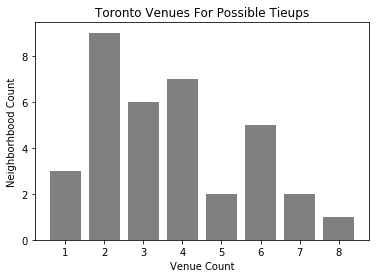

In [36]:
study_venuecount(toronto_venue_count,'Toronto')

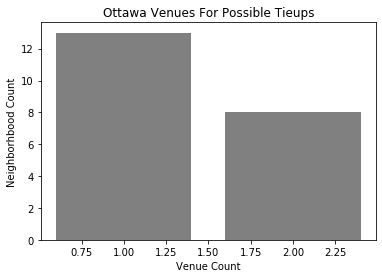

In [37]:
study_venuecount(ottawa_venue_count,'Ottawa')

Lets compare the employment income percentage of Toronto and Ottawa neighborhoods using pie charts. As the charts show below, Toronto neighborhood has relatively higher percentage than Ottawa. There are towns in Toronto with income more than 3% whereas Ottawa towns has nominal income only

In [38]:
def study_income(df, Boroname):
    slices = df['Income%']
    labels = df['Postalcode']
    plt.figure(figsize=(10,30))
    plt.pie(slices, labels = labels,wedgeprops={'edgecolor':'black'},
           startangle=90,autopct='%1.1f%%')
    plt.title('{} Borough Income Percentage Chart'.format(Boroname))
    plt.tight_layout
    plt.show

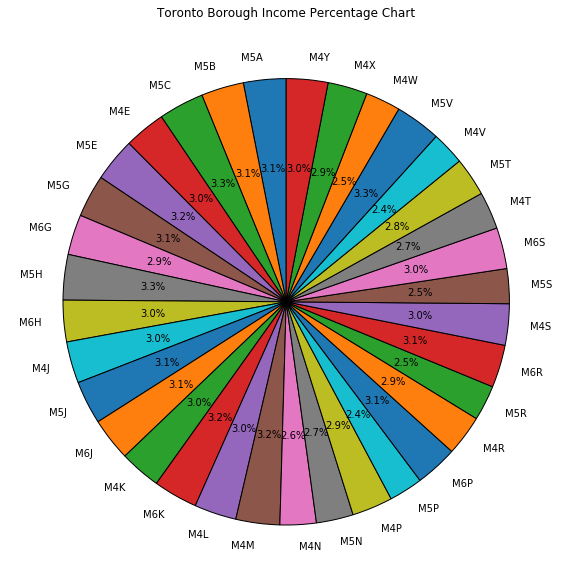

In [39]:
#Toronto Income Percentage analysis using pie chart
study_income(tor_census,'Toronto')

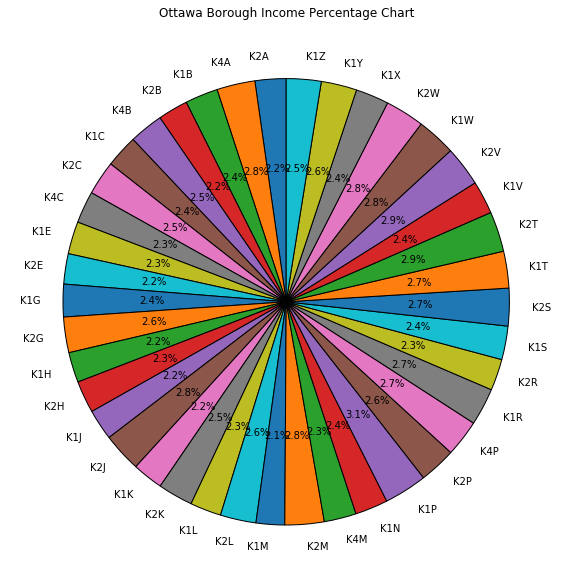

In [40]:
#Ottawa Income Percentage analysis using pie chart
study_income(otw_census,'Ottawa')

#### On analyzing the count of children ages 0-4 years, we can see that Ottawa has high density neighborhoods compared to Toronto.

In [41]:
#histogram charts
def study_childrencount(df, boroname):
    childrencount = df['ChildCount']
    bins=[0,500,1000,1500,2000,2500,3000,3500,4000]
    plt.grid()
    plt.title('Historgram of {} Children ages 0-4 years'.format(boroname))
    plt.xlabel('Total Count of Children ages 0-4 years')
    plt.ylabel('Neighborhood Count')
    plt.hist(childrencount,bins=bins,edgecolor='black', color='green')
    


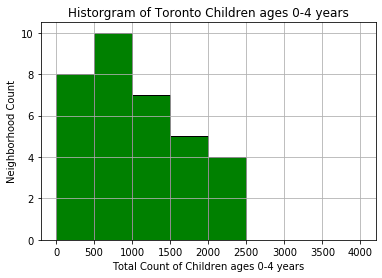

In [42]:
study_childrencount(tor_census, 'Toronto')

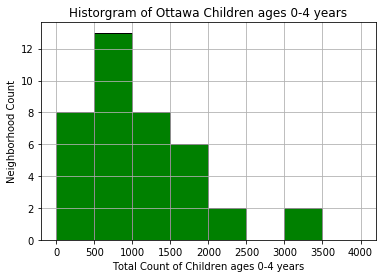

In [43]:
study_childrencount(otw_census, 'Ottawa')

#### As we are using multiple variables, K-means clustering algorithm will be the best approach to find groups which have not been explicitly labeled in the data. This can be used to confirm business assumptions about what types of groups exist or to identify unknown groups in complex data sets

To achieve the results using K-means let us combine all the three input dataframes,
 - Neighborhood data with geographical coordinates
 - Venue Count by Neighborhood
 - Census data by Neighborhood

In [44]:
ottawa_df = ottawa_df.join(otw_census.set_index('Postalcode'), on='Postalcode')
ottawa_df.set_index('Neighborhood')
ottawa_df = ottawa_df.join(ottawa_venue_count.set_index('Neighborhood'), on='Neighborhood' )
ottawa_df.dropna(subset=['VenueCount'],inplace=True)
ottawa_df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Income%,ChildCount,CFamilySize,LPFamilySize,VenueCount
0,K2A,Ottawa,"Highland Park, McKellar Park /Westboro /Glabar...",45.3884,-75.7456,65.1,710.0,3.9,2.5,2.0
1,K4A,Ottawa,Fallingbrook,45.4738,-75.4780,80.2,3460.0,4.1,2.8,1.0
3,K2B,Ottawa,"Britannia /Whitehaven, Bayshore, Pinecrest",45.3483,-75.8078,63.1,1695.0,4.1,2.8,1.0
5,K1C,Ottawa,Orleans,45.4558,-75.5047,68.6,1680.0,3.9,2.6,2.0
6,K2C,Ottawa,"Queensway, Copeland Park, Central Park, Bel Ai...",45.3643,-75.7478,71.7,1245.0,3.9,2.7,2.0


In [45]:
toronto_df = toronto_df.join(tor_census.set_index('Postalcode'), on='Postalcode')
toronto_df.set_index('Neighborhood')
toronto_df = toronto_df.join(toronto_venue_count.set_index('Neighborhood'), on='Neighborhood' )
toronto_df.dropna(subset=['ChildCount','CFamilySize', 'LPFamilySize', 'Income%','VenueCount'],inplace=True)
toronto_df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Income%,ChildCount,CFamilySize,LPFamilySize,VenueCount
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,82.2,1555.0,4.0,2.7,3.0
13,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,82.3,365.0,3.6,2.5,4.0
22,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,87.5,80.0,3.6,2.5,4.0
30,M4E,East Toronto,The Beaches,43.676357,-79.293031,79.9,1455.0,3.8,2.5,2.0
31,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,84.3,300.0,3.4,2.4,6.0


In [46]:
master_df = ottawa_df.append(toronto_df)
master_df.dropna(subset=['ChildCount','CFamilySize', 'LPFamilySize', 'Income%'],inplace=True)
master_clus_df = master_df.drop(['Postalcode','Borough', 'Neighborhood', 'Latitude', 'Longitude'], axis = 1)
master_clus_df.head()

,Income%,ChildCount,CFamilySize,LPFamilySize,VenueCount
0,65.1,710.0,3.9,2.5,2.0
1,80.2,3460.0,4.1,2.8,1.0
3,63.1,1695.0,4.1,2.8,1.0
5,68.6,1680.0,3.9,2.6,2.0
6,71.7,1245.0,3.9,2.7,2.0


Lets do the PCA analysis to check the validity of the features used.

[0.53191579 0.23657486 0.14431731 0.0551395  0.03205255]
['CFamilySize', 'Income%', 'VenueCount', 'ChildCount', 'CFamilySize']


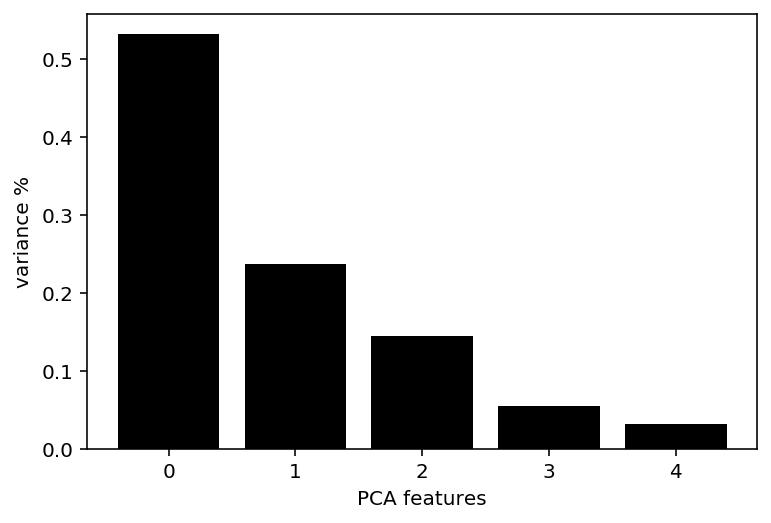

In [47]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'
allfeatures = master_clus_df.columns
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(master_clus_df)
# Create a PCA instance: pca
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
print(pca.explained_variance_ratio_)

principalFeaturesIndex = [np.abs(pca.components_[i]).argmax() for i in features]
principalFeatures = [allfeatures[principalFeaturesIndex[i]] for i in features]
print(principalFeatures)
PCA_components = pd.DataFrame(principalComponents)

As we can see above, the PCA lists that the CFamilySize, Income% and VenueCount covers the variance for 90% of the data. Lets now fit the PCA and plot the kmeans cluster with the inertia and idenity the best K.

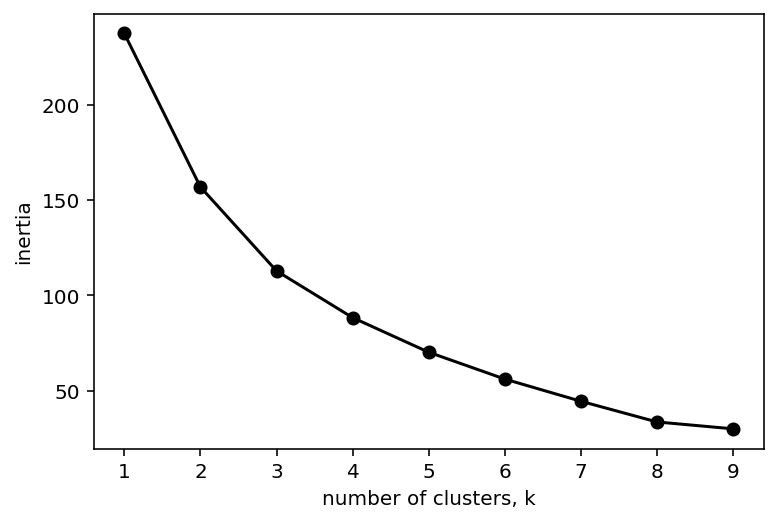

In [48]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

As we can see that there is not much variance in inertia after k=4, the optimum number of clusters for this analysis will be 4.

In [61]:
from sklearn.preprocessing import StandardScaler
X = master_clus_df.values[:,1:]
Clus_dataSet = StandardScaler().fit_transform(X)

In [73]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[1 0 4 4 4 2 1 4 3 4 1 1 1 1 1 1 4 2 0 4 4 4 1 1 4 1 1 4 1 2 1 4 4 4 2 4 1
 4 1 1 2 1 1 4 4 1 2 1 1 1 1 1]


In [74]:
master_df['ClusterLabels'] = labels

In [75]:
def map_display(address):
    
    #address = 'Ontario, Canada'

    geolocator = Nominatim(user_agent="tnt_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))
    return [latitude, longitude]

In [76]:
def map_display1(address, df):
    # create map
  #  coordinates = map_display('Ontario, Canada')
    coordinates = map_display(address)
 #   map_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)
    map_clusters = folium.Map(location=coordinates, zoom_start=10)

    # set color scheme for the clusters
    x = np.arange(clusterNum)
    ys = [i + x + (i*x)**2 for i in range(clusterNum)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
   # for lat, lon, poi, cluster in zip(master_df['Latitude'], master_df['Longitude'], master_df['Neighborhood'], master_df['ClusterLabels']):
    for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['ClusterLabels']): 
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

__As per the teaching staff comments on discussion forum, please try the below to view the map: The maps are not viewable in github.__

__One way is you can visit https://nbviewer.jupyter.org/ and enter the notebook github link and view it there.__

Discussion forum link: https://www.coursera.org/learn/applied-data-science-capstone/discussions/weeks/3/threads/ZjrqejTuEeuMagqWRQvY8w

In [77]:
map_display1('Ontario, Canada', master_df)

The geograpical coordinate of Ontario, Canada are 50.000678, -86.000977.


__As per the teaching staff comments on discussion forum, please try the below to view the map: The maps are not viewable in github.__

__One way is you can visit https://nbviewer.jupyter.org/ and enter the notebook github link and view it there.__

Discussion forum link: https://www.coursera.org/learn/applied-data-science-capstone/discussions/weeks/3/threads/ZjrqejTuEeuMagqWRQvY8w

In [78]:
toronto_clus_df = master_df[master_df['Borough'].str.contains('Toronto')]
# toronto_clus_df
map_display1('Toronto, Ontario', toronto_clus_df)

The geograpical coordinate of Toronto, Ontario are 43.6534817, -79.3839347.


__As per the teaching staff comments on discussion forum, please try the below to view the map: The maps are not viewable in github.__

__One way is you can visit https://nbviewer.jupyter.org/ and enter the notebook github link and view it there.__

Discussion forum link: https://www.coursera.org/learn/applied-data-science-capstone/discussions/weeks/3/threads/ZjrqejTuEeuMagqWRQvY8w

In [80]:
ottawa_clus_df = master_df[master_df['Borough'].str.contains('Ottawa')]
# toronto_clus_df
map_display1('Ottawa, Ontario', ottawa_clus_df)

The geograpical coordinate of Ottawa, Ontario are 45.421106, -75.690308.


In [81]:
##Cluster 1
master_df.loc[master_df['ClusterLabels'] == 0, master_df.columns[[1] + list(range(2, master_df.shape[1]))]]

,Borough,Neighborhood,Latitude,Longitude,Income%,ChildCount,CFamilySize,LPFamilySize,VenueCount,ClusterLabels
1,Ottawa,Fallingbrook,45.4738,-75.4780,80.2,3460.0,4.1,2.8,1.0,0
33,Ottawa,"Heron Gate, Heron Park, Riverside Park, Hunt C...",45.3776,-75.6522,69.4,3320.0,4.1,2.8,1.0,0


In [82]:
##Cluster 2
master_df.loc[master_df['ClusterLabels'] == 1, master_df.columns[[1] + list(range(2, master_df.shape[1]))]]

,Borough,Neighborhood,Latitude,Longitude,Income%,ChildCount,CFamilySize,LPFamilySize,VenueCount,ClusterLabels
0,Ottawa,"Highland Park, McKellar Park /Westboro /Glabar...",45.388400,-75.745600,65.1,710.0,3.9,2.5,2.0,1
12,Ottawa,"Alta Vista, Billings Bridge",45.387000,-75.657200,63.4,755.0,3.9,2.5,1.0,1
18,Ottawa,"Vanier, McKay Lake area",45.437100,-75.659000,65.3,710.0,3.7,2.5,2.0,1
20,Ottawa,"Rockcliffe Park, New Edinburgh",45.451300,-75.678000,59.9,275.0,3.8,2.5,2.0,1
24,Ottawa,Downtown,45.420600,-75.700700,90.2,10.0,3.0,2.0,2.0,1
25,Ottawa,Centretown,45.415300,-75.696400,76.8,355.0,3.6,2.4,1.0,1
27,Ottawa,Dalhousie Ward,45.411800,-75.705200,78.3,645.0,3.8,2.5,1.0,1
28,Ottawa,"Fallowfield Village, Cedarhill Estates, Orchar...",45.267400,-75.829800,65.9,40.0,4.1,2.2,1.0,1
13,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,82.3,365.0,3.6,2.5,4.0,1
22,Downtown Toronto,St. James Town,43.651494,-79.375418,87.5,80.0,3.6,2.5,4.0,1


In [83]:
##Cluster 3
master_df.loc[master_df['ClusterLabels'] == 2, master_df.columns[[1] + list(range(2, master_df.shape[1]))]]

,Borough,Neighborhood,Latitude,Longitude,Income%,ChildCount,CFamilySize,LPFamilySize,VenueCount,ClusterLabels
11,Ottawa,"Centrepointe, Meadowlands, City View, Craig He...",45.340900,-75.772500,74.6,2370.0,4.0,2.7,2.0,2
31,Ottawa,"Blossom Park, Greenboro, Leitrim, Findlay Creek",45.344300,-75.637600,77.1,2400.0,4.2,2.9,1.0,2
50,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,80.2,1970.0,3.9,2.6,2.0,2
75,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,81.3,2260.0,3.9,2.6,2.0,2
104,West Toronto,"High Park, The Junction South",43.661608,-79.464763,81.9,2210.0,3.8,2.5,4.0,2
122,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,79.5,2175.0,3.8,2.6,3.0,2


In [84]:
##Cluster 4
master_df.loc[master_df['ClusterLabels'] == 3, master_df.columns[[1] + list(range(2, master_df.shape[1]))]]

,Borough,Neighborhood,Latitude,Longitude,Income%,ChildCount,CFamilySize,LPFamilySize,VenueCount,ClusterLabels
15,Ottawa,Barrhaven,45.2737,-75.7372,81.9,4775.0,4.1,2.8,1.0,3


In [85]:
##Cluster 5
master_df.loc[master_df['ClusterLabels'] == 4, master_df.columns[[1] + list(range(2, master_df.shape[1]))]]

,Borough,Neighborhood,Latitude,Longitude,Income%,ChildCount,CFamilySize,LPFamilySize,VenueCount,ClusterLabels
3,Ottawa,"Britannia /Whitehaven, Bayshore, Pinecrest",45.348300,-75.807800,63.1,1695.0,4.1,2.8,1.0,4
5,Ottawa,Orleans,45.455800,-75.504700,68.6,1680.0,3.9,2.6,2.0,4
6,Ottawa,"Queensway, Copeland Park, Central Park, Bel Ai...",45.364300,-75.747800,71.7,1245.0,3.9,2.7,2.0,4
13,Ottawa,"Bells Corners, Arlington Woods/Redwood, Qualic...",45.324700,-75.826700,67.4,1275.0,3.9,2.6,1.0,4
17,Ottawa,"Beaverbrook, South March",45.326100,-75.901500,73.5,1205.0,4.0,2.7,1.0,4
29,Ottawa,"The Glebe, Old Ottawa South, Old Ottawa East, ...",45.387600,-75.696000,70.4,1195.0,3.9,2.5,1.0,4
38,Ottawa,"Civic Hospital, Island Park, Hintonburg, Mecha...",45.398800,-75.736200,74.9,1000.0,3.8,2.5,1.0,4
39,Ottawa,"Westboro, Carlington",45.388400,-75.745600,73.0,1245.0,4.0,2.7,2.0,4
4,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,82.2,1555.0,4.0,2.7,3.0,4
30,East Toronto,The Beaches,43.676357,-79.293031,79.9,1455.0,3.8,2.5,2.0,4


## Results<a id='results'></a>

The most powerful method of visualizing high dimensional data is using Principal component Analysis in conjunction with k-means data.As per the PCA analysis, we can confirm the variables applied is meaningful as the variance drop indicates.The principal components when fit to the k-means algorithm provides the best number of clusters. The ideal number of clusters for the k-means model has been done using inertia, by measuring the sum of the squared distances to the nearest cluster center. The k-means scree plot below indicates the percentage of variance as the function of the number of clusters. After the 5th cluster, the change in the value of inertia is not significant and neither is the variance of the rest of the data. Therefore we can discard everything after k=5. 

## Conclusion<a id='conclusion'></a>

The original goal of the project was to identify the neighborhoods in Toronto and Ottawa borough where they can establish the modern daycare center servicing only ages 0-4 years. The neighborhood was required to have fairly large amount of kids with families having optimum income and have venue options to support business tieups.
In the above analysis, we have identified that cluster# 4 provides the optimum list of neighborhoods, satisfying the requirements as below:
 - The count of children 0-4 age years is >=2000
 - The income reange is >=75%
 - The venue count for business tie-ups is also available.
 
__Of cluster# 3, the best suited neighborhood for the daycare is HighPark, The Junction South in East Toronto and for Ottawa borough, the option will be Centrepointe, Meadowlands, City View, Craig Henry, Tangelwood, Grenfell Glen, Davidson Heights.__